In [1]:
import numpy as np
import pandas as pd
import xgboost as xg
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import time
import pylab as pl
from IPython import display


In [2]:
# Считывание данных из csv файла
data = pd.read_csv("cases3.csv",header=None)

# Количество месяцев расчёта на симуляторе
month_count = 61

# Необходимо указать количество кейсов для обучения, валидации и тестирования
train_count = 400
valid_count = 100
test_count = 800

# Разделение считанных данных на обучающую, валидационную и тестовую выборки
data_train = data.iloc[:,0:train_count]
data_valid = data.iloc[:,train_count:train_count+valid_count]
data_test = data.iloc[:,train_count+valid_count:train_count
                      +valid_count+test_count]


In [3]:
# Вывод таблицы с данными в JupyterLab

# в таблице: столбцы - кейсы расчитанные на симуляторе (каждый
# со своими значениями входных параметров)

# строка 0 - пористость матрицы (входной параметр)

# строка 1 - проницаемость матрицы (входной параметр)

# строка 2 - пористость трещин (входной параметр)

# строка 3 - проницаемость трещин (входной параметр)

# строки 4-64 - дебиты нефти по месяцам 0-60 (выходные параметры)

data


,0,1,2,3,4,5,6,7,8,9,...,2590,2591,2592,2593,2594,2595,2596,2597,2598,2599
0,0.177500,0.178375,0.170875,0.162750,0.15400,0.171500,0.165125,0.191500,0.199125,0.151375,...,0.147500,0.146937,0.152938,0.156625,0.144937,0.149812,0.146250,0.142563,0.145063,0.142187
1,8.350625,2.321875,4.938125,5.950500,2.76550,7.122125,5.700250,3.698250,4.983625,2.094375,...,6.121125,5.643375,8.384750,6.661437,8.344938,6.712625,7.275688,6.581812,6.803625,7.668125
2,0.038413,0.013213,0.027669,0.041787,0.02120,0.037738,0.036275,0.015688,0.029750,0.043306,...,0.023534,0.030200,0.035234,0.033659,0.040691,0.027106,0.035966,0.034588,0.033350,0.035797
3,444.875000,596.000000,335.187500,286.437500,1115.18750,1629.500000,1124.937500,1280.937500,1529.562500,622.812500,...,890.937500,899.468750,1479.593750,1206.593750,1358.937500,1528.343750,752.000000,1005.500000,1415.000000,1198.062500
4,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,104.290400,99.050500,103.492400,112.334300,57.25322,79.515710,78.553020,76.748740,96.573110,93.296790,...,42.695320,54.767280,54.630770,62.151570,57.229840,42.279860,59.718810,52.815480,48.348240,50.135350
61,98.798740,94.800750,97.641110,106.395000,54.44020,74.696330,74.203210,73.048580,92.013830,88.830380,...,39.877550,49.773280,50.924390,58.318130,53.381210,39.311170,56.399070,48.649310,44.987610,46.649430
62,93.620640,90.854000,92.039750,100.811100,51.68710,70.065650,70.094350,69.882840,87.565950,85.645460,...,36.909990,46.441210,47.347190,54.547230,49.684350,36.507560,52.897370,45.478400,41.848600,43.482940
63,88.625320,86.658030,86.808980,95.556920,49.04267,65.394470,66.034550,66.419120,83.170890,82.389550,...,33.729560,43.583130,44.038810,50.976020,46.217120,33.738820,48.960950,42.475460,38.841030,40.440670


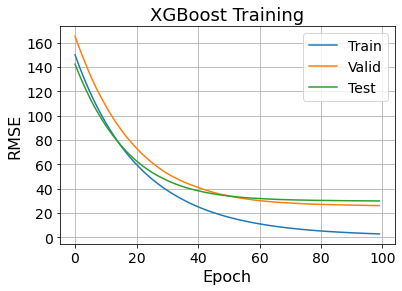

In [4]:
# Массив для построенных XGBoost метамоделей (для каждого месяца своя модель)
XGB_models = []

# В цикле для каждого месяца строится своя XGBoost метамодель
for month_current in range(1,month_count):
    
    # Разделение входных и целевых данных
    X_train,T_train = data_train.iloc[:-month_count,:].transpose(), \
                      data_train.iloc[month_current-month_count,:]
    X_valid,T_valid = data_valid.iloc[:-month_count,:].transpose(), \
                      data_valid.iloc[month_current-month_count,:]
    X_test,T_test = data_test.iloc[:-month_count,:].transpose(), \
                      data_test.iloc[month_current-month_count,:]
    xgb_r = xg.XGBRegressor(learning_rate=0.05,n_estimators=100,
                            max_depth=100,gamma=0)
    #xgb_r = xg.XGBRegressor(learning_rate=0.009,n_estimators=1000,
    #min_child_weight=0.03,max_depth=10)
    #xgb_r = xg.XGBRegressor()
    
    # Наборы, на которых будут проводиться обучение, валидация и тестирование
    eval_set = [(X_train,T_train),(X_valid,T_valid),(X_test,T_test)]
    
    # Обучение
    xgb_r.fit(X_train,T_train,eval_metric=["rmse"],
              eval_set=eval_set,verbose=False)
    XGB_models.append(xgb_r)
    
    # Вывод истории процесса обучения (значений функции потерь)
    if month_current == 7:
        results=xgb_r.evals_result()
        epochs=len(results['validation_0']['rmse'])
        x_axis=range(0,epochs)
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize']=[7,7]
        ax.plot(x_axis,results['validation_0']['rmse'],label='Train')
        ax.plot(x_axis,results['validation_1']['rmse'],label='Valid')
        ax.plot(x_axis,results['validation_2']['rmse'],label='Test')
        ax.legend(fontsize=14)
        plt.xlabel('Epoch',fontsize=16)
        plt.xticks(fontsize=14)
        plt.ylabel('RMSE',fontsize=16)
        plt.yticks(fontsize=14)
        plt.title('XGBoost Training',fontsize=18)
        plt.grid(which='both')
        plt.show()


Text(0, 0.5, 'Ошибка, в процентах')

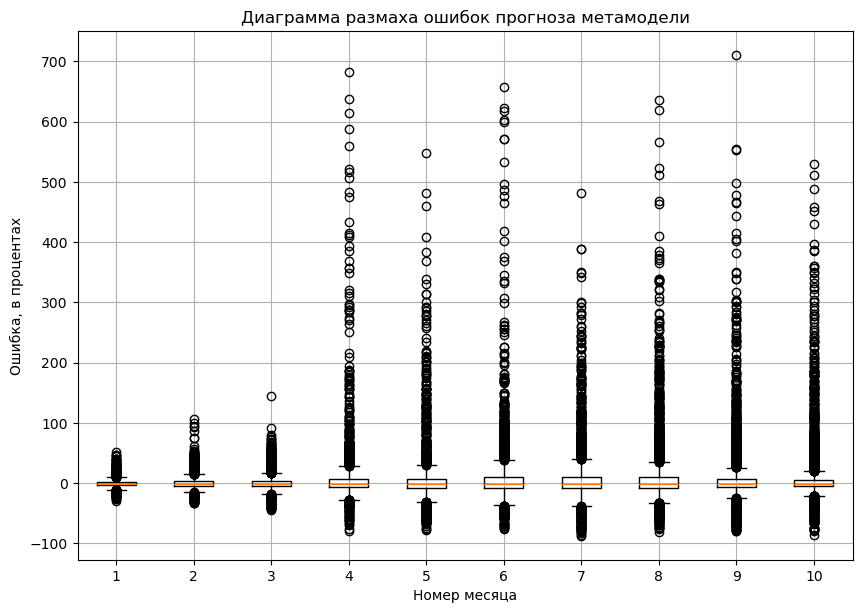

In [5]:
# Прогноз
months_for_forecast = 11 #количество месяцев для прогноза
rel_errors = {}
for month_current in range(1,months_for_forecast):
    X,T = data.iloc[:-month_count,:].transpose(), \
          data.iloc[month_current-month_count,:]
    Y = XGB_models[month_current-1].predict(X)
    abs_err = list(np.subtract(Y,T))
    rel_errors[str(month_current)] = np.divide(abs_err,T)*100
plt.figure(figsize=(10, 7), dpi=100)
plt.boxplot(rel_errors.values())
plt.grid(which='both')
plt.title('Диаграмма размаха ошибок прогноза метамодели')
plt.xlabel('Номер месяца')
plt.ylabel('Ошибка, в процентах')

#print(XGB_models[month_current-1].feature_importances_)
#rel_err #ошибка по кейсам на валидационной выборке в процентах


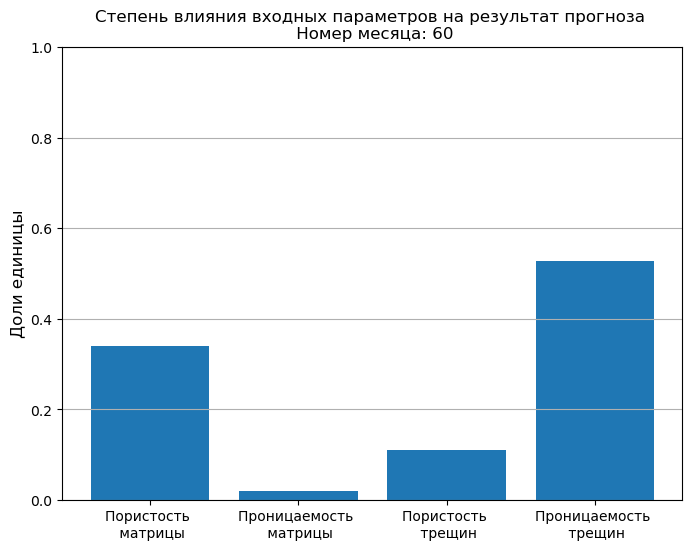

<Figure size 432x288 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

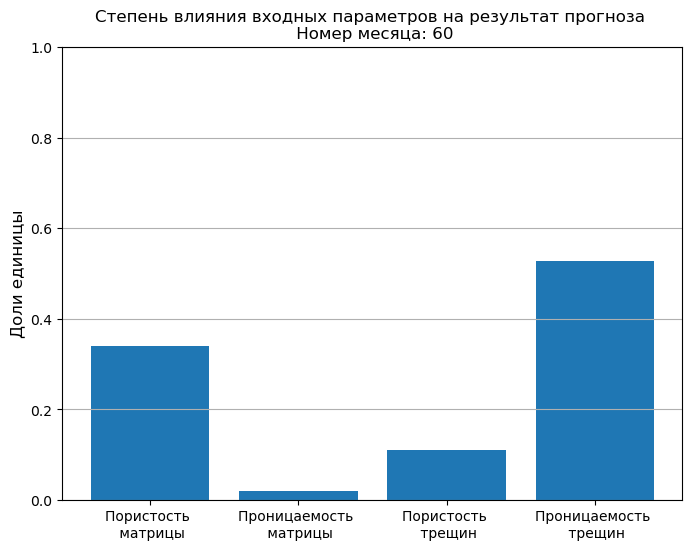

In [6]:
# Визуализация степени влияния входных параметров на результат расчёта (для
# каждого месяца)

%matplotlib inline

bars = ('Пористость \n матрицы','Проницаемость \n матрицы',
        'Пористость \n трещин','Проницаемость \n трещин')
x_pos = np.arange(len(bars))
for i in range(1,month_count):
    plt.clf()
    plt.figure(figsize=(8, 6), dpi=100)
    plt.ylim((0,1))
    plt.ylabel('Доли единицы',fontsize=12)
    plt.grid(axis='y')
    plt.title('Степень влияния входных параметров на результат прогноза '
              + '\n Номер месяца: ' + str(i))
    plt.bar(range(len(XGB_models[i-1].feature_importances_)),
            XGB_models[i-1].feature_importances_,label='d')
    plt.xticks(x_pos,bars)
    display.clear_output(wait=True)
    display.display(pl.gcf())
    #if i==1:
    #    time.sleep(10)
    time.sleep(0.3)
